In [4]:
'''Colorization autoencoder
The autoencoder is trained with grayscale images as input
and colored images as output.
Colorization autoencoder can be treated like the opposite
of denoising autoencoder. Instead of removing noise, colorization
adds noise (color) to the grayscale image.
Grayscale Images --> Colorization --> Color Images
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [6]:
# load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()


170508288/170498071 [==============================] - 2s 0us/step


In [7]:
x_train.shape

(50000, 32, 32, 3)

In [8]:
# input image dimensions
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

In [9]:
# create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

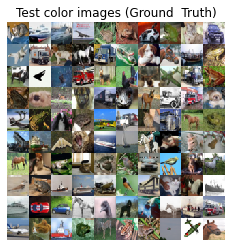

In [11]:
# display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [12]:
# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

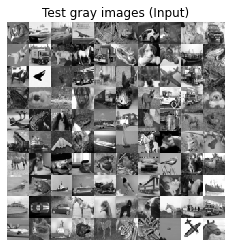

In [13]:
# display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [14]:
# normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [15]:
# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [16]:
# reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

In [17]:
# reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [14]:
# network parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 512
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256, 512]

In [15]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [ ]:
# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

In [17]:
# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [18]:
# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 512)         1180160   
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 latent_vector (Dense)       (None, 512)               1049

In [19]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [20]:
# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

In [21]:
outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [22]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 2048)              1050624   
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        2359808   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        1179904   
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 16, 16, 128)      2950

In [23]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 512)               2598912   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         4960899   
                                                                 
Total params: 7,559,811
Trainable params: 7,559,811
Non-trainable params: 0
_________________________________________________________________


In [24]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [25]:
# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [26]:
# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

In [27]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam', metrics='acc')

In [28]:
# called every epoch
callbacks = [lr_reducer, checkpoint]

In [29]:
# train the autoencoder
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0192 - acc: 0.4692
Epoch 00001: val_loss improved from inf to 0.01458, saving model to /content/saved_models/colorized_ae_model.001.h5
1563/1563 [==============================] - 83s 47ms/step - loss: 0.0192 - acc: 0.4692 - val_loss: 0.0146 - val_acc: 0.4247 - lr: 0.0010
Epoch 2/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0135 - acc: 0.4882
Epoch 00002: val_loss improved from 0.01458 to 0.01253, saving model to /content/saved_models/colorized_ae_model.002.h5
1563/1563 [==============================] - 72s 46ms/step - loss: 0.0135 - acc: 0.4882 - val_loss: 0.0125 - val_acc: 0.4868 - lr: 0.0010
Epoch 3/30
1562/1563 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.4983
Epoch 00003: val_loss improved from 0.01253 to 0.01181, saving model to /content/saved_models/colorized_ae_model.003.h5
1563/1563 [==============================] - 76s 48ms/step - loss: 0.0123 - acc: 0.4983 -

In [30]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

In [32]:
autoencoder.evaluate(x_test_gray,x_test)

313/313 [==============================] - 6s 19ms/step - loss: 0.0093 - acc: 0.5054


[0.009338834322988987, 0.5053749084472656]

In [34]:
x_d = autoencoder.predict(x_test_gray[:1])

In [1]:
from keras.models import load_model
AE = load_model('colorized_ae_model.021.h5')

In [18]:

x1 = AE.predict(x_test_gray)

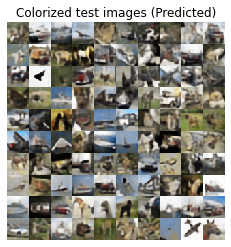

In [19]:
# display the 1st 100 colorized images
imgs = x1[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()